In [343]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

# Загружаем датасет

In [344]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

labels, data = np.asfarray(train['labels']) , np.asfarray(train['data']) # Сonversion to float!

Run = 0

In [345]:
# Show i'th image
def show_image(img):
    plt.imshow(img.reshape(28,28))

In [346]:
# Normalizing and classification -1,+1
def pixel_norm(x):
    for i,pixel in enumerate(x):
        x[i] = pixel/255
    return x

def classification(y):
    for i,label in enumerate(y):
        y[i]=-1 if label==5 else 1
    return y

data = pixel_norm(data)
labels = classification(labels)

# Создание модели

In [347]:
# Creating two perceptrons in output layer
'''Global weight declaration for multiple Runs capabilities'''

global w
np.random.seed(10)
if Run == 0:
    w = np.ndarray((2, data.shape[1]))
    w[0] = np.random.normal(scale=0.001, size = data.shape[1])
    w[1] = np.random.normal(scale=0.001, size = data.shape[1])
print("Run: ", Run)

Run:  0


In [348]:
# k-fold Cross Validation Scheme with shuffling
'''k-fold must be 'None' or 2,3..'''

k_fold = 4

def cross_validation(data, labels):
    global x_train, y_train
    data_set = np.insert(data, 0, labels, axis=1) # Insert labels(y) in each image(x) row
    random.shuffle(data_set)
    if k_fold != None:
        global x_valid, y_valid 
        train = np.asarray([x for i, x in enumerate(data_set) if (i+2) % k_fold != 1])
        valid = np.asarray([x for i, x in enumerate(data_set) if (i+2) % k_fold == 1])
        y_train, x_train = train[:, 0], train[:, np.r_[1:train.shape[1]]] 
        y_valid, x_valid = valid[:, 0], valid[:, np.r_[1:train.shape[1]]]
        print("Training images:", x_train.shape[0])
        print("Validation images:", x_valid.shape[0])
    else:
        train = np.asarray(data_set)
        y_train, x_train = train[:, 0], train[:, np.r_[1:train.shape[1]]]
        print("Validation images:", x_train.shape[0])

cross_validation(data, labels)

loss_train = []
loss_valid = []
acc_train = []
acc_valid = []

Training images: 7500
Validation images: 2500


# Обучаем модель

In [349]:
# Stochastic gradient descent
reg_param = 0.1
def sgd(x, y, weight):
    return (-1)*y*x/(1 + np.exp(y*np.dot(weight.T, x))) + reg_param*weight

In [350]:
# Logloss calculation
def lgs(x, y, weight):
    return np.log(1 + np.exp(- y*np.dot(weight.T, x)))

In [351]:
# Learning steps
learn_rate = 0.00001
def lrn_step(x, y, weight):
    weight -= learn_rate*sgd(x, y, weight)
    return weight

In [352]:
def evaluate(x, y, loss):
    for iter in range(y.shape[0]):
        i = np.random.randint(0, high=y.shape[0])
        if (y[i] == -1):
            j = 0
        else:
            j = 1
        w[j] = lrn_step(x[i], y[i], w[j])    
        logloss = lgs(x[i], y[i], w[j])
        loss = np.append(loss, logloss) 
    return loss

loss_train = evaluate(x_train, y_train, loss_train)
loss_valid = evaluate(x_valid, y_valid, loss_valid)

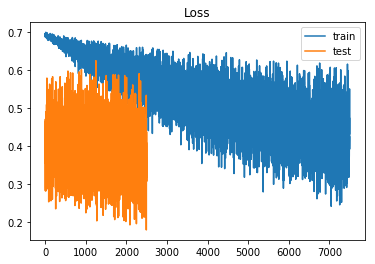

In [356]:
plt.title('Loss')
plt.plot(loss_train, label='train')
plt.plot(loss_valid, label='test')
plt.legend()

In [368]:
def predict(x): 
    p = np.zeros(2, x.shape[1])
    for i in range(x.shape[1]):
        p = (1. / (1. + np.exp(-np.dot(w.T, x[i]))))
    return p

p_train = predict(x_train)
print(p_train)

TypeError: data type not understood

In [188]:
p = predict(w)
    
print(p[0])

ValueError: shapes (7500,784) and (2,784) not aligned: 784 (dim 1) != 2 (dim 0)

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

In [ ]:
plt.title('Loss')
plt.plot(logloss_array[0], label='train')
#plt.plot([e[0] for e in te_eval], label='test')
plt.legend()

In [ ]:
"""
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend()
"""

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [ ]:
X = test_no_lables['data']

# compute Y_pred

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(test['labels'])):
        print(i, Y_pred[i], sep=',', file=fout)

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МИФИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем family.ipynb